In [2]:
import torch 
from torchvision.models import Inception3
from torch import nn
import numpy as np 
import cv2
from google.colab.patches import cv2_imshow
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch import nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt 
from PIL import Image
import torchvision.transforms as T

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

In [4]:
def loadModel():
    model = Inception3(num_classes=2, aux_logits=True, transform_input=False)
    model = model.to('cpu')
    checkpoint = torch.load('/content/drive/MyDrive/Fagproject/GentofteTrainVal.tar',map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [5]:
img_transform = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_data_dir = datasets.ImageFolder("/content/drive/MyDrive/Fagproject/Billeder", transform = img_transform)
unnormdata = datasets.ImageFolder("/content/drive/MyDrive/Fagproject/Billeder",transform = transforms.ToTensor())
un_loader = torch.utils.data.DataLoader(unnormdata, batch_size=1, shuffle=False)
un_normalized = list(un_loader)
train_loader = torch.utils.data.DataLoader(train_data_dir, batch_size=1, shuffle=False)
#unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

In [6]:
img_tensors = []
for x,y in train_loader:
  img_tensors.append(x)

In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model = loadModel()
model.eval()

In [9]:
model.Mixed_7c.register_forward_hook(get_activation('7C'))

In [10]:
len(img_tensors)

580

In [10]:
featuremaps = []
for i in range(560,570):
  activation = {}
  img = img_tensors[i]
  #img = img[:,:,:].transpose(1,2)
  with torch.no_grad():
    logits = model(img[:,:,:])
  feature_map = activation['7C']
  fcpos = list(model.fc.parameters())[0][1].detach().numpy()
  p = F.softmax(logits)

  featuremaps.append((un_normalized[i],feature_map,p,i))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [141]:
featuremaps[0][3]

560

In [11]:
fp = {}
index = []
for (x,fm,p,i) in featuremaps: 
  print(p)
  if p[0,1] > 0.5: 
    fp[i] = (x,fm,p)
    index.append(i)

tensor([[0.8507, 0.1493]])
tensor([[0.6866, 0.3134]])
tensor([[0.0026, 0.9974]])
tensor([[0.0030, 0.9970]])
tensor([[0.5865, 0.4135]])
tensor([[0.7726, 0.2274]])
tensor([[0.0362, 0.9638]])
tensor([[0.0223, 0.9777]])
tensor([[0.3348, 0.6652]])
tensor([[0.8410, 0.1590]])


In [75]:
feature_map1 = fp[index[0]][1]
idx1 = index[0]
p1 = np.around(fp[index[0]][2][0,1].item(), decimals = 3)

feature_map2 = fp[index[1]][1]
idx2 = index[1]
p2 = np.around(fp[index[1]][2][0,1].item(), decimals = 3)

feature_map3 = fp[index[-1]][1]
idx3 = index[-1]
p3 = np.around(fp[index[-1]][2][0,1].item(), decimals = 3)

In [76]:
p1

0.997

In [74]:
print(np.around(p3.item(),decimals = 3))

0.665


In [51]:
print(feature_map1.shape,feature_map2.shape)

torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])


In [61]:
def get_cam(feature_map,fcpos):
  
  bz, nc, h, w = feature_map.shape
  size_upsample = (299,299)

  beforeDot =  feature_map.reshape((nc, h*w))
  cam = np.matmul(fcpos, beforeDot)
  cam = cam.reshape(h, w)
  cam = cam - np.min(cam.detach().numpy())
  cam_img = cam / np.max(cam.detach().numpy())
  cam_img = np.uint8(255 * cam_img)
  output_cam = cv2.resize(cam_img, size_upsample)
  return output_cam

output_cam1 = get_cam(feature_map=feature_map1,fcpos = fcpos)
output_cam2 = get_cam(feature_map=feature_map2,fcpos = fcpos)
output_cam3 = get_cam(feature_map=feature_map3,fcpos = fcpos)

In [54]:
fp[idx1][0][0].shape

torch.Size([1, 3, 320, 320])

In [62]:
#imgs = cv2.resize(img[0,:,:,:],(299,299))
hm1 = cv2.applyColorMap(cv2.resize(output_cam1,(320, 320)), cv2.COLORMAP_JET)
hm2 = cv2.applyColorMap(cv2.resize(output_cam2,(320, 320)), cv2.COLORMAP_JET)
hm3 = cv2.applyColorMap(cv2.resize(output_cam3,(320, 320)), cv2.COLORMAP_JET)

transform = T.ToPILImage()
#Get image 1
tensor1 = fp[idx1][0][0][0,:,:,:]#un_normalized[idx1][0][0,:,:,:]
img1 = transform(tensor1)
img1
img1 = np.array(img1)

#Get image 2
tensor2 = fp[idx2][0][0][0,:,:,:] #un_normalized[idx2][0][0,:,:,:]
img2 = transform(tensor2)
img2
img2 = np.array(img2)

#Get image 3
tensor3 = fp[idx3][0][0][0,:,:,:] #un_normalized[idx2][0][0,:,:,:]
img3 = transform(tensor3)
img3
img3 = np.array(img3)

In [61]:
img1.shape

(320, 320, 3)

In [46]:
plt.rcParams['figure.figsize'] = [10, 12]

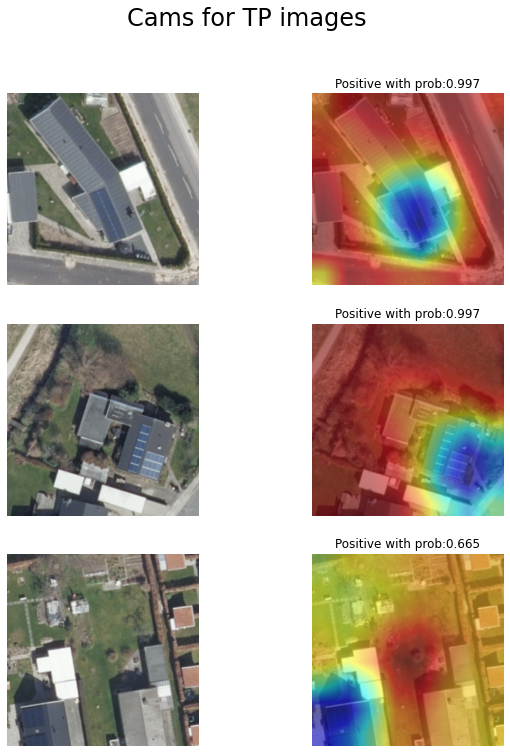

In [78]:
fig, axs = plt.subplots(3,2)
fig.tight_layout
axs[0,0].imshow(img1)
axs[0,0].axis('off')
axs[0,1].imshow(img1)
axs[0,1].imshow(hm1,alpha = 0.5)
axs[0,1].title.set_text(f'Positive with prob:{p1}')
axs[0,1].axis('off')

axs[1,0].imshow(img2)
axs[1,0].axis('off')
axs[1,1].imshow(img2)
axs[1,1].imshow(hm2,alpha = 0.5)
axs[1,1].title.set_text(f'Positive with prob:{p2}')
axs[1,1].axis('off')

axs[2,0].imshow(img3)
axs[2,0].axis('off')
axs[2,1].imshow(img3)
axs[2,1].imshow(hm3,alpha = 0.5)
axs[2,1].title.set_text(f'Positive with prob:{p3}')
axs[2,1].axis('off')

fig.suptitle('Cams for TP images', fontsize=24)

fig.show()

In [51]:
F.softmax(logits)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.9942, 0.0058]], grad_fn=<SoftmaxBackward0>)

Plot billeder som figur

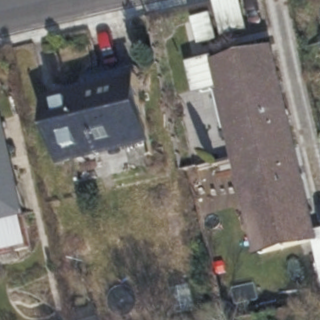

In [130]:
tensor = un_normalized[2][0][0,:,:,:]
transform = T.ToPILImage()
img = transform(tensor)
img

In [98]:
un_normalized[0][0].shape

torch.Size([1, 3, 299, 299])

In [109]:
x = cv2.cvtColor(un_normalized[0][0][0,:,:,:].numpy().transpose(1,2,0),cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


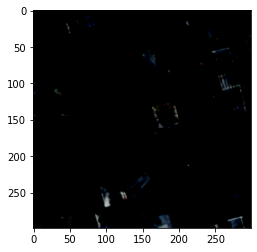

In [110]:
plt.imshow(x)

In [74]:
imgs = featuremaps[0][0].numpy()[0,:,:,:].transpose(1,2,0)
imgs.shape

(299, 299, 3)

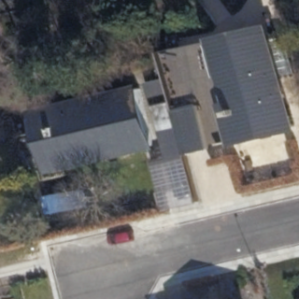

In [ ]:
cv2_imshow(imgs.transpose(0,1,2))

In [ ]:
std0 = img[0,:,:,0].float().std()
std1 = img[0,:,:,1].float().std()
std2 = img[0,:,:,2].float().std()

m0 = img[0,:,:,0].float().mean()
m1 = img[0,:,:,1].float().mean()
m2 = img[0,:,:,2].float().mean()

In [ ]:
hm = cv2.applyColorMap(cv2.resize(output_cam,(320, 320)), cv2.COLORMAP_JET)

In [92]:
imgs = cv2.imread('/content/drive/MyDrive/Fagproject/Billeder/negative/Neg1.png')
img = torch.tensor(imgs)
model.eval()
img = img[None,:,:,:]